# Tutorial 3: Network Topologies

This tutorial explores complex network topologies in `braintools.conn`. You'll learn how to create biologically-plausible network architectures with specific graph properties.

---

## 1. Introduction to Network Topologies <a name="introduction"></a>

Network topology refers to the global structure of connections in a network, beyond local connectivity rules.

### Why Network Topology Matters

- **Computational Efficiency**: Topology affects information processing speed and capacity
- **Robustness**: Network resilience to damage depends on topology
- **Biological Realism**: Real brains exhibit specific topological features (small-world, modularity)
- **Functional Specialization**: Modular structures support specialized processing

### Common Network Properties

- **Clustering Coefficient**: Local connectivity density
- **Path Length**: Average distance between neurons
- **Degree Distribution**: How connections are distributed
- **Modularity**: Presence of distinct communities

Let's start by importing the necessary libraries:

In [1]:
import brainunit as u
import matplotlib.pyplot as plt
import numpy as np

from braintools import conn, visualize as vis
from braintools.init import Constant, Normal

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['font.size'] = 10

print("✓ Imports successful")

✓ Imports successful


---

## 2. Small-World Networks <a name="small-world"></a>

Small-world networks combine high local clustering with short global path lengths, a hallmark of brain connectivity.

### 2.1 The Watts-Strogatz Model

The Watts-Strogatz model creates small-world networks by:
1. Starting with a regular ring lattice (high clustering, long paths)
2. Rewiring edges with probability `p` (introducing shortcuts)

Parameter `p` controls the transition:
- `p = 0`: Regular lattice
- `0 < p < 1`: Small-world
- `p = 1`: Random graph

In [2]:
# Create small-world network
n_neurons = 500

small_world = conn.SmallWorld(
    k=10,  # Each neuron connects to 10 neighbors (5 on each side)
    p=0.1,  # 10% rewiring probability
    weight=Constant(1.0 * u.nS),
    seed=42
)

result_sw = small_world(pre_size=n_neurons, post_size=n_neurons)

print("Small-World Network (Watts-Strogatz):")
print("=" * 50)
print(f"Neurons: {n_neurons}")
print(f"Neighbors (k): 10")
print(f"Rewiring probability (p): 0.1")
print(f"Total connections: {len(result_sw.pre_indices)}")
print(f"Expected: {n_neurons * 10} (n × k)")
print(f"Connections per neuron: {len(result_sw.pre_indices) / n_neurons:.1f}")

Small-World Network (Watts-Strogatz):
Neurons: 500
Neighbors (k): 10
Rewiring probability (p): 0.1
Total connections: 5000
Expected: 5000 (n × k)
Connections per neuron: 10.0


### 2.2 Effect of Rewiring Probability

Let's compare networks with different rewiring probabilities:

In [3]:
# Create networks with varying rewiring probability
rewiring_probs = [0.0, 0.05, 0.1, 0.3, 0.5, 1.0]
n_test = 200

results_by_p = {}
for p in rewiring_probs:
    sw = conn.SmallWorld(k=6, p=p, seed=42)
    result = sw(pre_size=n_test, post_size=n_test)
    results_by_p[p] = result

print("Rewiring Probability Effects:")
print("=" * 60)
print(f"{'p':<10} {'Connections':<15} {'Description'}")
print("=" * 60)
for p in rewiring_probs:
    result = results_by_p[p]
    desc = "Regular lattice" if p == 0 else ("Random graph" if p == 1.0 else "Small-world")
    print(f"{p:<10.2f} {len(result.pre_indices):<15} {desc}")

Rewiring Probability Effects:
p          Connections     Description
0.00       1200            Regular lattice
0.05       1200            Small-world
0.10       1200            Small-world
0.30       1200            Small-world
0.50       1200            Small-world
1.00       1200            Random graph


### 2.3 Degree Distribution Analysis

Small-world networks maintain relatively uniform degree distribution:

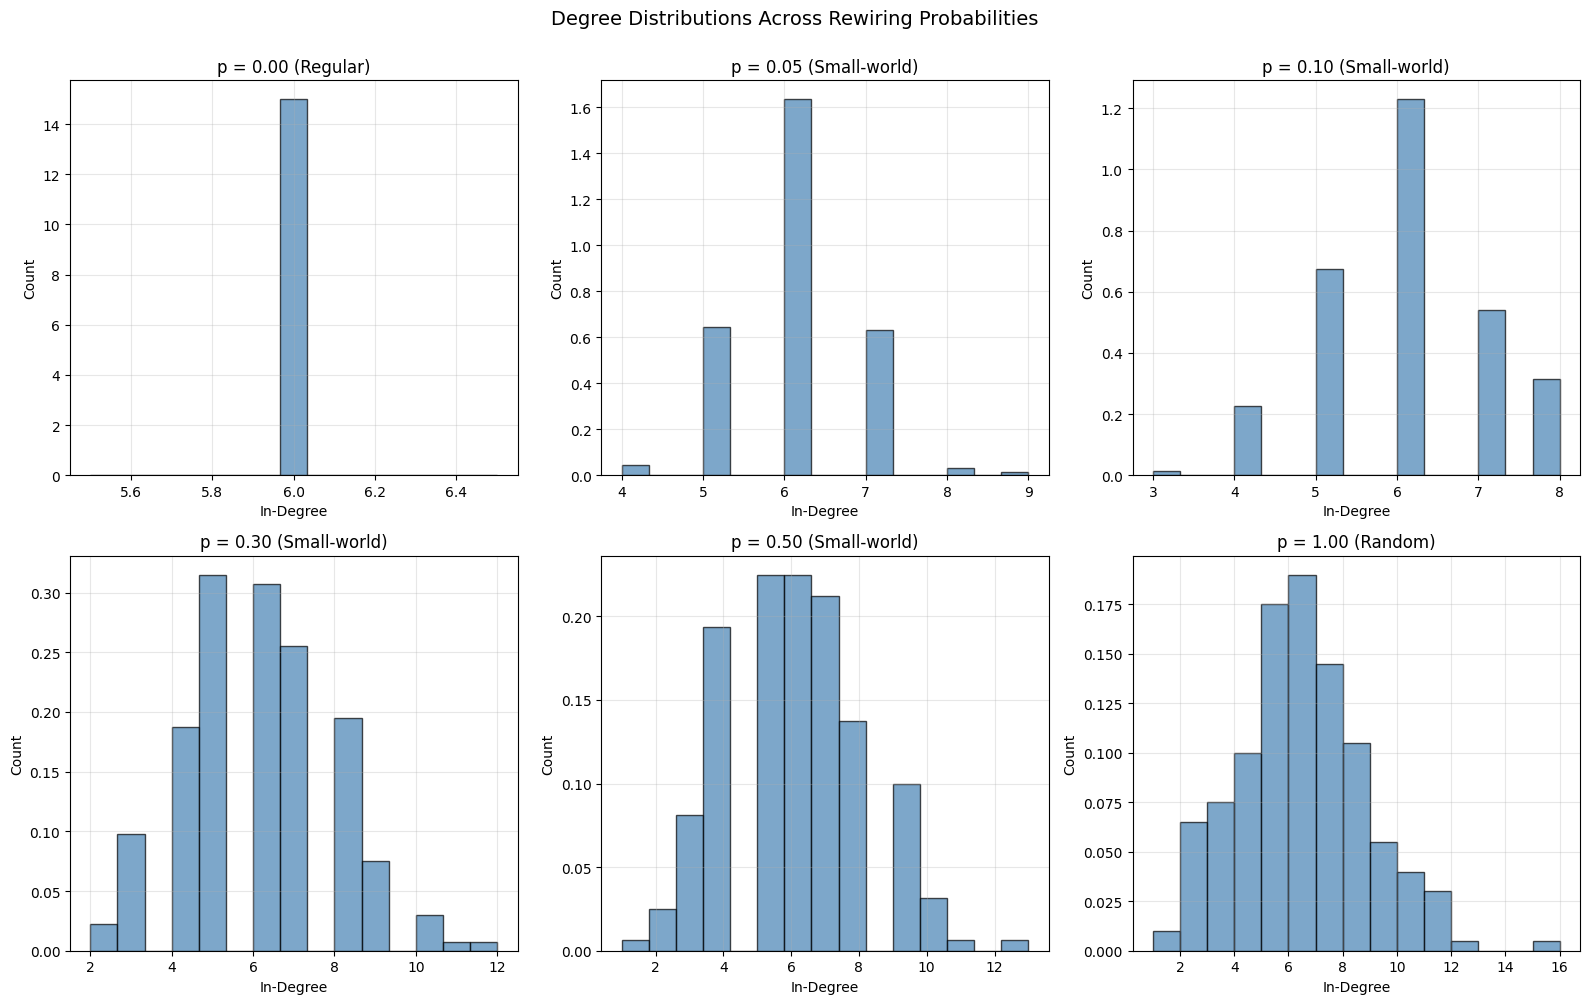


Key Observations:
- p=0.0 (Regular): All neurons have exactly k=6 connections
- 0<p<1 (Small-world): Narrow distribution around k=6
- p=1.0 (Random): Still centered on k=6 but with more variance


In [4]:
# Calculate degree distributions for different p values
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.flatten()

for idx, p in enumerate(rewiring_probs):
    result = results_by_p[p]
    in_degree = np.bincount(result.post_indices, minlength=n_test)

    title = f"p = {p:.2f} ({['Regular', 'Small-world', 'Small-world', 'Small-world', 'Small-world', 'Random'][idx]})"

    vis.distribution_plot(
        in_degree,
        bins=15,
        alpha=0.7,
        colors=['steelblue'],
        edgecolor='black',
        ax=axes[idx],
        xlabel='In-Degree',
        ylabel='Count',
        title=title
    )

plt.suptitle('Degree Distributions Across Rewiring Probabilities', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("- p=0.0 (Regular): All neurons have exactly k=6 connections")
print("- 0<p<1 (Small-world): Narrow distribution around k=6")
print("- p=1.0 (Random): Still centered on k=6 but with more variance")

---

## 3. Scale-Free Networks <a name="scale-free"></a>

Scale-free networks have degree distributions following a power law, with a few highly connected "hub" neurons.

### 3.1 Barabási-Albert Model

The Barabási-Albert model creates scale-free networks through preferential attachment:

In [5]:
# Create scale-free network
scale_free = conn.ScaleFree(
    m=3,  # Each new neuron connects to 3 existing neurons
    weight=Constant(1.0 * u.nS),
    seed=42
)

result_sf = scale_free(pre_size=n_neurons, post_size=n_neurons)

print("Scale-Free Network (Barabási-Albert):")
print("=" * 50)
print(f"Neurons: {n_neurons}")
print(f"Edges per new neuron (m): 3")
print(f"Total connections: {len(result_sf.pre_indices)}")
print(f"Average degree: {len(result_sf.pre_indices) / n_neurons:.1f}")

# Analyze hub neurons
in_degree_sf = np.bincount(result_sf.post_indices, minlength=n_neurons)
out_degree_sf = np.bincount(result_sf.pre_indices, minlength=n_neurons)
total_degree_sf = in_degree_sf + out_degree_sf

print(f"\nHub Analysis:")
print(f"  Max degree: {np.max(total_degree_sf)}")
print(f"  Min degree: {np.min(total_degree_sf[total_degree_sf > 0])}")
print(f"  Top 5 hubs (degree): {sorted(total_degree_sf, reverse=True)[:5]}")

Scale-Free Network (Barabási-Albert):
Neurons: 500
Edges per new neuron (m): 3
Total connections: 2988
Average degree: 6.0

Hub Analysis:
  Max degree: 188
  Min degree: 6
  Top 5 hubs (degree): [np.int64(188), np.int64(148), np.int64(130), np.int64(108), np.int64(64)]


### 3.2 Scale-Free vs. Small-World Degree Distributions

Compare the degree distributions:

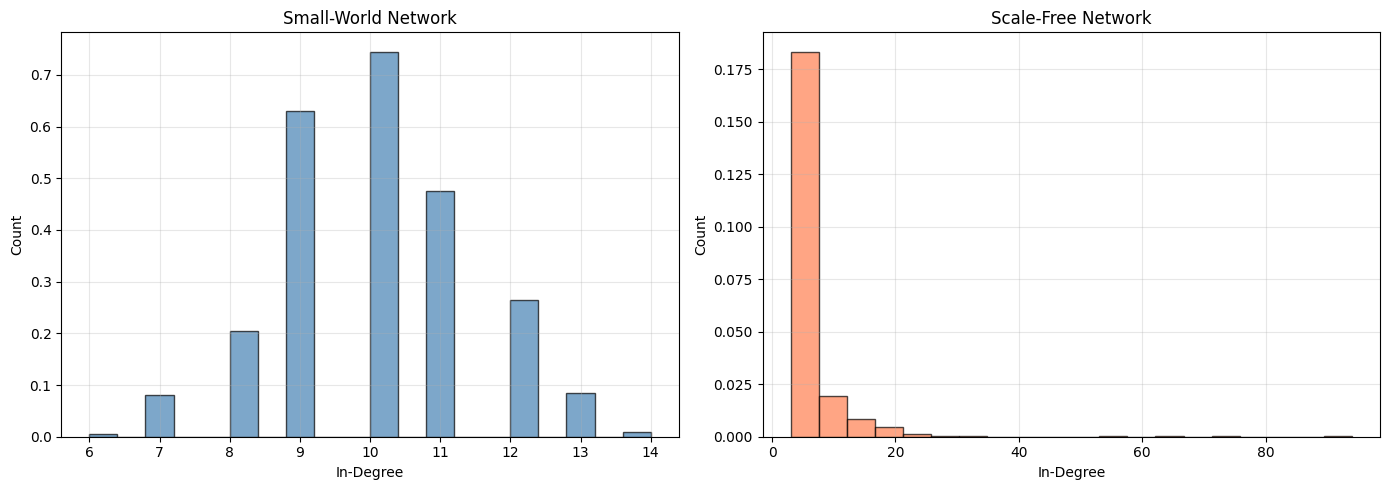


Key Differences:
- Small-World: Narrow, bell-shaped distribution (homogeneous connectivity)
- Scale-Free: Heavy-tailed distribution (heterogeneous, with hubs)

Coefficient of Variation (std/mean):
  Small-World: 0.137
  Scale-Free: 1.208


In [6]:
# Calculate degrees
in_degree_sw = np.bincount(result_sw.post_indices, minlength=n_neurons)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

vis.distribution_plot(
    in_degree_sw,
    bins=20,
    alpha=0.7,
    colors=['steelblue'],
    edgecolor='black',
    ax=axes[0],
    xlabel='In-Degree',
    ylabel='Count',
    title='Small-World Network'
)

vis.distribution_plot(
    in_degree_sf,
    bins=20,
    alpha=0.7,
    colors=['coral'],
    edgecolor='black',
    ax=axes[1],
    xlabel='In-Degree',
    ylabel='Count',
    title='Scale-Free Network'
)

plt.tight_layout()
plt.show()

print("\nKey Differences:")
print("- Small-World: Narrow, bell-shaped distribution (homogeneous connectivity)")
print("- Scale-Free: Heavy-tailed distribution (heterogeneous, with hubs)")
print(f"\nCoefficient of Variation (std/mean):")
print(f"  Small-World: {np.std(in_degree_sw) / np.mean(in_degree_sw):.3f}")
print(f"  Scale-Free: {np.std(in_degree_sf) / np.mean(in_degree_sf):.3f}")

### 3.3 Log-Log Plot for Power Law

Scale-free networks exhibit power-law degree distributions:

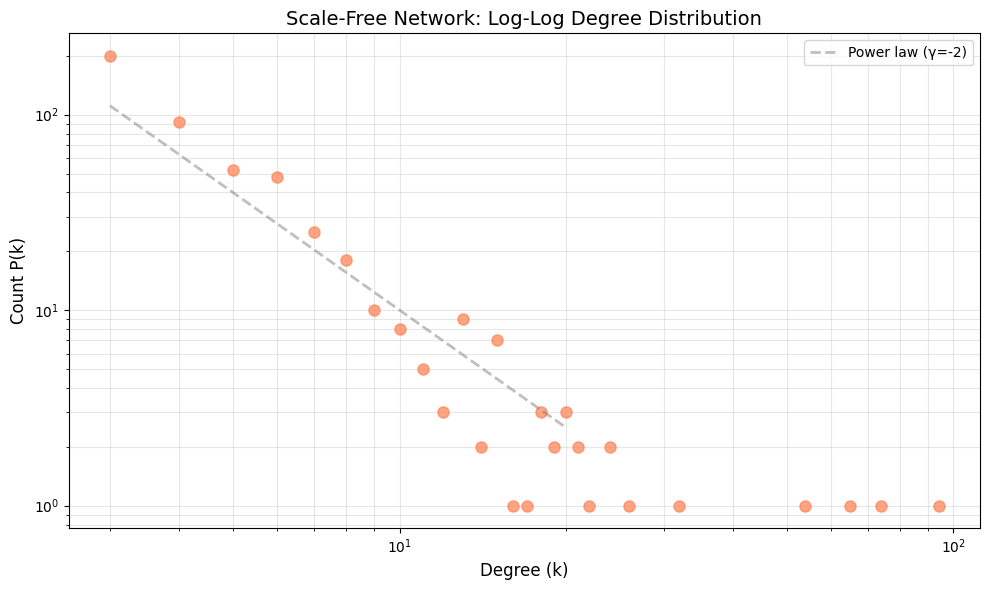


In a scale-free network, degree distribution follows P(k) ~ k^(-γ)
The log-log plot shows an approximately linear relationship.


In [7]:
# Calculate degree distribution
unique_degrees, degree_counts = np.unique(in_degree_sf, return_counts=True)

# Remove zero degree
nonzero_mask = unique_degrees > 0
unique_degrees = unique_degrees[nonzero_mask]
degree_counts = degree_counts[nonzero_mask]

# Plot log-log
fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(unique_degrees, degree_counts, 'o', markersize=8, alpha=0.7, color='coral')
ax.set_xlabel('Degree (k)', fontsize=12)
ax.set_ylabel('Count P(k)', fontsize=12)
ax.set_title('Scale-Free Network: Log-Log Degree Distribution', fontsize=14)
ax.grid(True, alpha=0.3, which='both')

# Add power law reference line
x_fit = np.array([unique_degrees.min(), 20])
y_fit = 1000 * x_fit ** (-2.)  # Power law with exponent -2
ax.loglog(x_fit, y_fit, '--', color='gray', linewidth=2, alpha=0.5, label='Power law (γ=-2)')
ax.legend()

plt.tight_layout()
plt.show()

print("\nIn a scale-free network, degree distribution follows P(k) ~ k^(-γ)")
print("The log-log plot shows an approximately linear relationship.")

---

## 4. Regular Networks <a name="regular"></a>

Regular networks have deterministic, structured connectivity where all neurons have the same degree.

### 4.1 k-Regular Networks

In [8]:
# Create regular network
regular = conn.Regular(
    degree=8,  # Each neuron has exactly 8 connections
    weight=Constant(1.0 * u.nS),
    seed=42
)

result_regular = regular(pre_size=200, post_size=200)

print("Regular Network:")
print("=" * 50)
print(f"Neurons: 200")
print(f"Degree (k): 8")
print(f"Total connections: {len(result_regular.pre_indices)}")
print(f"Expected: {200 * 8} (n × k)")

# Verify regularity
in_degree_reg = np.bincount(result_regular.post_indices, minlength=200)
print(f"\nRegularity check:")
print(f"  All in-degrees equal to {8}: {np.all(in_degree_reg == 8)}")
print(f"  Unique in-degrees: {np.unique(in_degree_reg)}")

Regular Network:
Neurons: 200
Degree (k): 8
Total connections: 1600
Expected: 1600 (n × k)

Regularity check:
  All in-degrees equal to 8: False
  Unique in-degrees: [ 2  3  4  5  6  7  8  9 10 11 12 13 14 15]


### 4.2 Comparing Regular, Small-World, and Random

Visualize the structural differences:

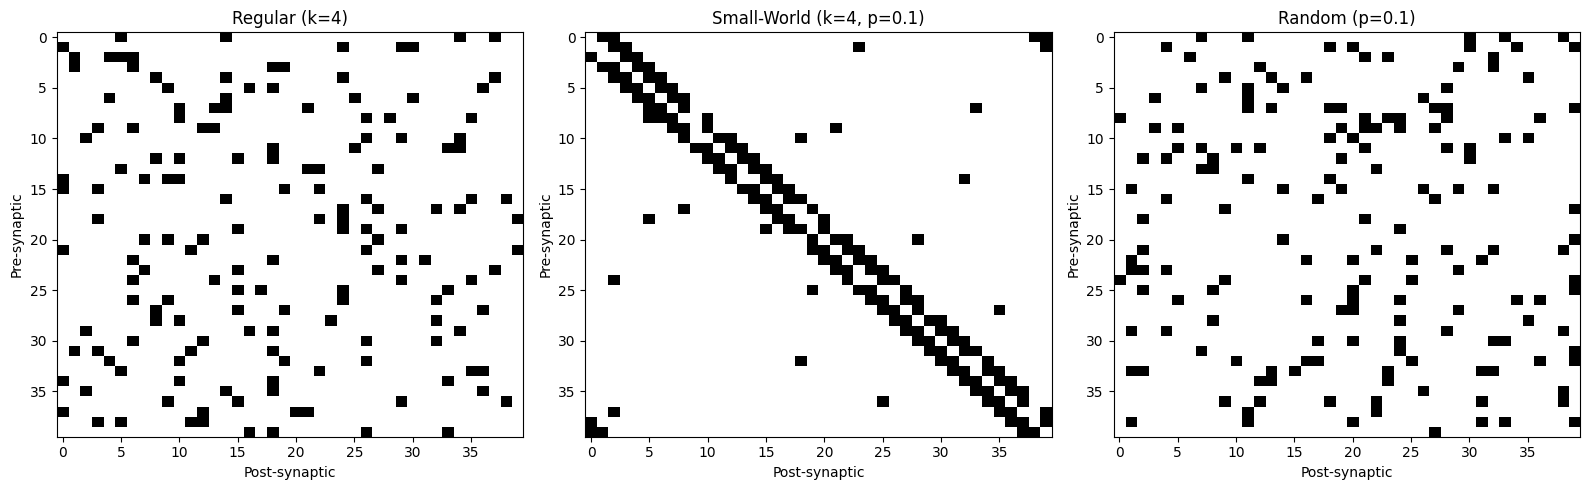


Matrix Structures:
- Regular: Clear banded structure (local connections)
- Small-World: Bands with scattered long-range connections
- Random: Uniform random distribution


In [9]:
# Create small test networks for visualization
n_viz = 40

regular_viz = conn.Regular(degree=4, seed=42)(pre_size=n_viz, post_size=n_viz)
sw_viz = conn.SmallWorld(k=4, p=0.1, seed=42)(pre_size=n_viz, post_size=n_viz)
random_viz = conn.Random(prob=0.1, seed=42)(pre_size=n_viz, post_size=n_viz)


# Create connectivity matrices
def result_to_matrix(result, size):
    matrix = np.zeros((size, size))
    matrix[result.pre_indices, result.post_indices] = 1
    return matrix


matrix_regular = result_to_matrix(regular_viz, n_viz)
matrix_sw = result_to_matrix(sw_viz, n_viz)
matrix_random = result_to_matrix(random_viz, n_viz)

# Plot matrices
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

vis.connectivity_matrix(matrix_regular, cmap='binary', center_zero=False,
                        show_colorbar=False, ax=axes[0], title='Regular (k=4)')
vis.connectivity_matrix(matrix_sw, cmap='binary', center_zero=False,
                        show_colorbar=False, ax=axes[1], title='Small-World (k=4, p=0.1)')
vis.connectivity_matrix(matrix_random, cmap='binary', center_zero=False,
                        show_colorbar=False, ax=axes[2], title='Random (p=0.1)')

plt.tight_layout()
plt.show()

print("\nMatrix Structures:")
print("- Regular: Clear banded structure (local connections)")
print("- Small-World: Bands with scattered long-range connections")
print("- Random: Uniform random distribution")

---

## 5. Modular Networks <a name="modular"></a>

Modular networks have distinct communities with dense intra-module and sparse inter-module connections.

### 5.1 Modular Random Networks

Create modules with different connection probabilities:

In [10]:
# Create modular network with 4 modules
modular = conn.ModularRandom(
    n_modules=4,  # 4 distinct modules
    intra_prob=0.3,  # 30% connectivity within modules
    inter_prob=0.02,  # 2% connectivity between modules
    weight=Constant(1.0 * u.nS),
    seed=42
)

result_modular = modular(pre_size=400, post_size=400)

print("Modular Random Network:")
print("=" * 50)
print(f"Neurons: 400")
print(f"Modules: 4 (100 neurons each)")
print(f"Intra-module probability: 30%")
print(f"Inter-module probability: 2%")
print(f"Total connections: {len(result_modular.pre_indices)}")
print(f"Average degree: {len(result_modular.pre_indices) / 400:.1f}")

Modular Random Network:
Neurons: 400
Modules: 4 (100 neurons each)
Intra-module probability: 30%
Inter-module probability: 2%
Total connections: 14189
Average degree: 35.5


### 5.2 Custom Module Configurations

Use `ModularGeneral` for flexible module sizes and connection probabilities:

In [11]:
# Create custom modular network with different module sizes
module_sizes = [80, 120, 100, 100]  # Unequal module sizes

# Connection probability matrix (4×4 for 4 modules)
prob_matrix = np.array([
    [0.4, 0.05, 0.02, 0.01],  # Module 0: strongly connected internally
    [0.05, 0.3, 0.1, 0.02],  # Module 1: moderate internal, some connection to 2
    [0.02, 0.1, 0.35, 0.05],  # Module 2: moderate internal
    [0.01, 0.02, 0.05, 0.25]  # Module 3: weaker internal connectivity
])

modular_general = conn.ModularGeneral(
    intra_conn=[conn.Random(0.4), conn.Random(0.3), conn.Random(0.35), conn.Random(0.25)],
    inter_conn_pair={
        (0, 1): conn.Random(0.05),
        (0, 2): conn.Random(0.02),
        (0, 3): conn.Random(0.01),
        (1, 2): conn.Random(0.1),
        (1, 3): conn.Random(0.02),
        (2, 3): conn.Random(0.05),
        # bi
        (1, 0): conn.Random(0.05),
        (2, 0): conn.Random(0.02),
        (3, 0): conn.Random(0.01),
        (2, 1): conn.Random(0.1),
        (3, 1): conn.Random(0.02),
        (3, 2): conn.Random(0.05),
    },
)

result_modular_gen = modular_general(pre_size=400, post_size=400)

print("Custom Modular Network (ModularGeneral):")
print("=" * 50)
print(f"Neurons: 400")
print(f"Module sizes: {module_sizes}")
print(f"Total connections: {len(result_modular_gen.pre_indices)}")
print(f"\nConnection probability matrix:")
print(prob_matrix)

Custom Modular Network (ModularGeneral):
Neurons: 400
Module sizes: [80, 120, 100, 100]
Total connections: 17810

Connection probability matrix:
[[0.4  0.05 0.02 0.01]
 [0.05 0.3  0.1  0.02]
 [0.02 0.1  0.35 0.05]
 [0.01 0.02 0.05 0.25]]


### 5.3 Visualizing Modular Structure

The block-diagonal structure reveals modularity:

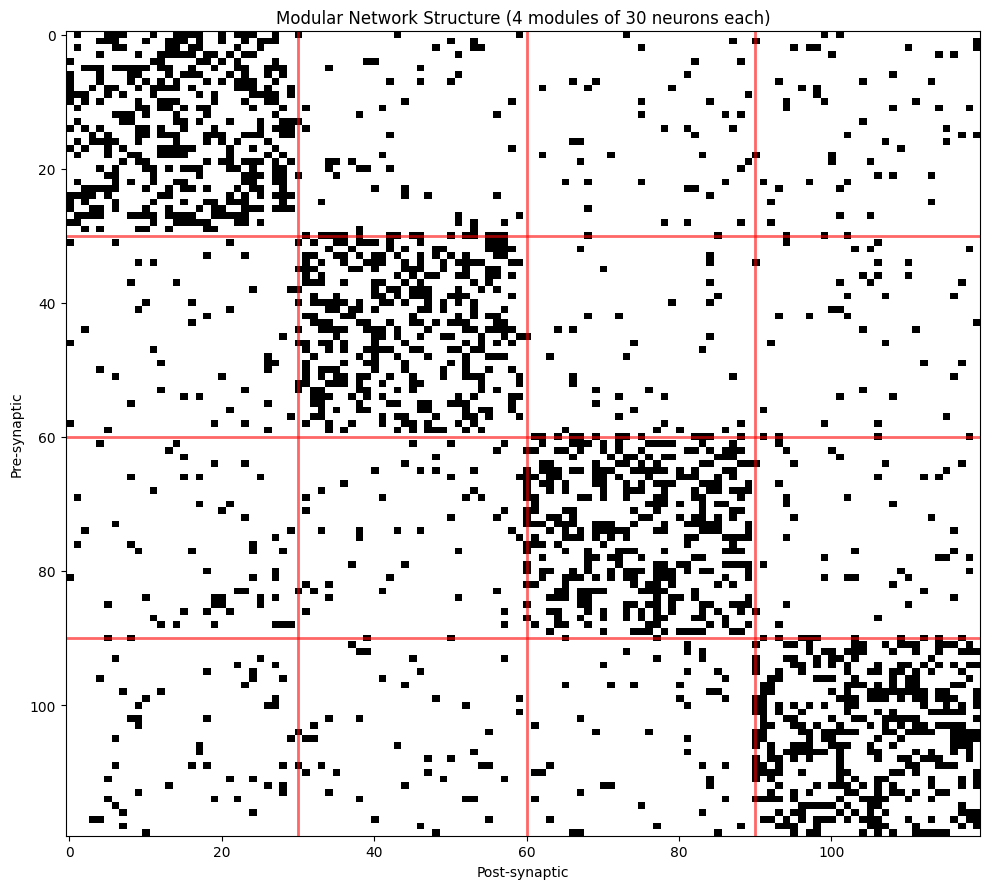


Red lines mark module boundaries.
Dense blocks on diagonal = intra-module connections.
Sparse off-diagonal = inter-module connections.


In [12]:
# Create smaller modular network for visualization
modular_viz = conn.ModularRandom(
    n_modules=4,
    intra_prob=0.4,
    inter_prob=0.05,
    seed=42
)(pre_size=120, post_size=120)

matrix_modular = result_to_matrix(modular_viz, 120)

# Plot
fig, ax = plt.subplots(figsize=(10, 9))
vis.connectivity_matrix(
    matrix_modular,
    cmap='binary',
    center_zero=False,
    show_colorbar=False,
    ax=ax,
    title='Modular Network Structure (4 modules of 30 neurons each)'
)

# Add module boundary lines
module_size = 30
for i in range(1, 4):
    boundary = i * module_size
    ax.axhline(boundary, color='red', linewidth=2, alpha=0.6)
    ax.axvline(boundary, color='red', linewidth=2, alpha=0.6)

plt.tight_layout()
plt.show()

print("\nRed lines mark module boundaries.")
print("Dense blocks on diagonal = intra-module connections.")
print("Sparse off-diagonal = inter-module connections.")

---

## 6. Hierarchical Networks <a name="hierarchical"></a>

Hierarchical networks organize neurons into levels with feedforward and feedback connections.

### 6.1 Creating Hierarchical Structures

In [13]:
# Create hierarchical network with 3 levels
hierarchical = conn.HierarchicalRandom(
    n_levels=3,  # 3 hierarchical levels
    feedforward_prob=0.3,  # Probability of feedforward connections
    feedback_prob=0.1,  # Probability of feedback connections
    recurrent_prob=0.2,  # Probability of lateral connections within level
    weight=Constant(1.0 * u.nS),
    seed=42
)

result_hierarchical = hierarchical(pre_size=300, post_size=300)

print("Hierarchical Network:")
print("=" * 50)
print(f"Neurons: 300 (100 per level)")
print(f"Levels: 3")
print(f"Forward probability: 30%")
print(f"Backward probability: 10%")
print(f"Lateral probability: 20%")
print(f"Total connections: {len(result_hierarchical.pre_indices)}")

Hierarchical Network:
Neurons: 300 (100 per level)
Levels: 3
Forward probability: 30%
Backward probability: 10%
Lateral probability: 20%
Total connections: 13968


### 6.2 Visualizing Hierarchical Organization

Hierarchical structure shows as off-diagonal bands:

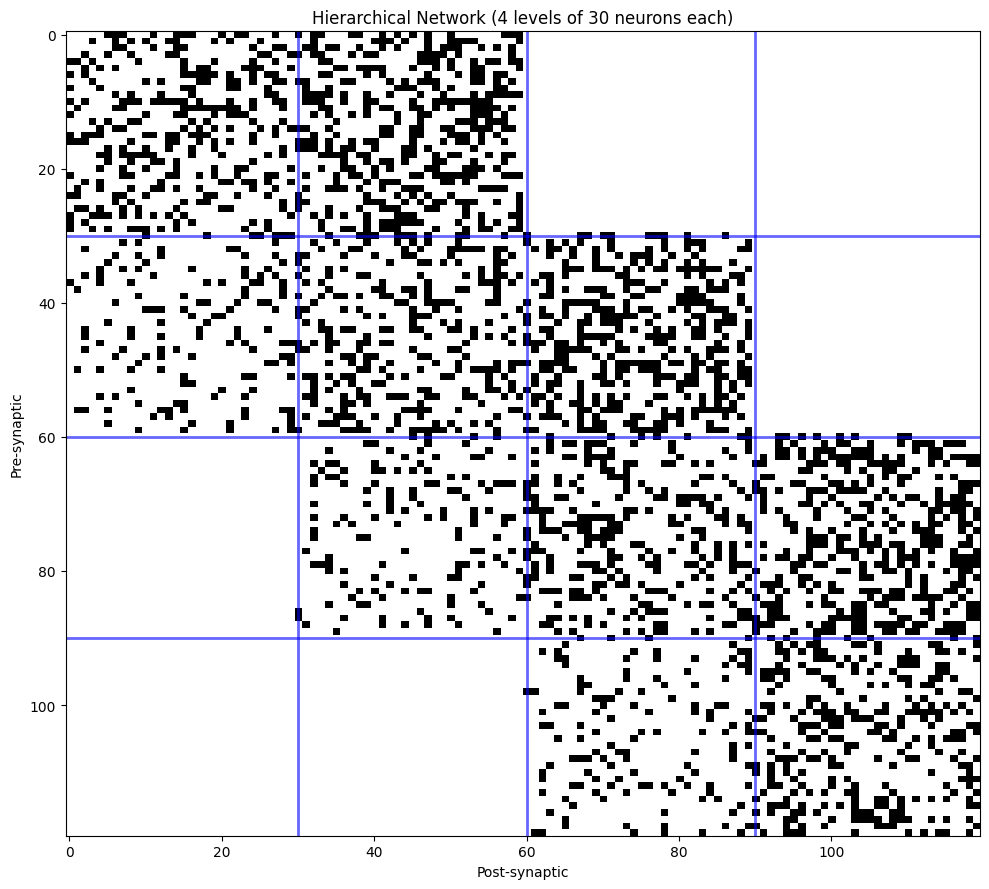


Blue lines mark level boundaries.
Diagonal blocks = lateral (within-level) connections.
Upper off-diagonal = feedforward connections.
Lower off-diagonal = feedback connections.


In [14]:
# Create smaller hierarchical network for visualization
hierarchical_viz = conn.HierarchicalRandom(
    n_levels=4,
    feedforward_prob=0.4,
    feedback_prob=0.15,
    recurrent_prob=0.3,
    seed=42
)(pre_size=120, post_size=120)

matrix_hierarchical = result_to_matrix(hierarchical_viz, 120)

# Plot
fig, ax = plt.subplots(figsize=(10, 9))
vis.connectivity_matrix(
    matrix_hierarchical,
    cmap='binary',
    center_zero=False,
    show_colorbar=False,
    ax=ax,
    title='Hierarchical Network (4 levels of 30 neurons each)'
)

# Add level boundary lines
level_size = 30
for i in range(1, 4):
    boundary = i * level_size
    ax.axhline(boundary, color='blue', linewidth=2, alpha=0.6)
    ax.axvline(boundary, color='blue', linewidth=2, alpha=0.6)

plt.tight_layout()
plt.show()

print("\nBlue lines mark level boundaries.")
print("Diagonal blocks = lateral (within-level) connections.")
print("Upper off-diagonal = feedforward connections.")
print("Lower off-diagonal = feedback connections.")

---

## 7. Core-Periphery Structures <a name="core-periphery"></a>

Core-periphery networks have a densely connected core and a sparsely connected periphery.

### 7.1 Creating Core-Periphery Networks

In [16]:
# Create core-periphery network
core_periphery = conn.CorePeripheryRandom(
    core_size=100,  # 100 neurons in core
    core_core_prob=0.5,  # 50% connectivity within core
    core_periphery_prob=0.1,  # 10% core→periphery
    periphery_core_prob=0.15,  # 15% periphery→core
    periphery_periphery_prob=0.02,  # 2% within periphery
    weight=Constant(1.0 * u.nS),
    seed=42
)

result_cp = core_periphery(pre_size=400, post_size=400)

print("Core-Periphery Network:")
print("=" * 50)
print(f"Total neurons: 400")
print(f"Core neurons: 100")
print(f"Periphery neurons: 300")
print(f"\nConnection probabilities:")
print(f"  Core ↔ Core: 50%")
print(f"  Core → Periphery: 10%")
print(f"  Periphery → Core: 15%")
print(f"  Periphery ↔ Periphery: 2%")
print(f"\nTotal connections: {len(result_cp.pre_indices)}")

Core-Periphery Network:
Total neurons: 400
Core neurons: 100
Periphery neurons: 300

Connection probabilities:
  Core ↔ Core: 50%
  Core → Periphery: 10%
  Periphery → Core: 15%
  Periphery ↔ Periphery: 2%

Total connections: 14203


### 7.2 Analyzing Core vs. Periphery Connectivity

Compare degree distributions between core and periphery:

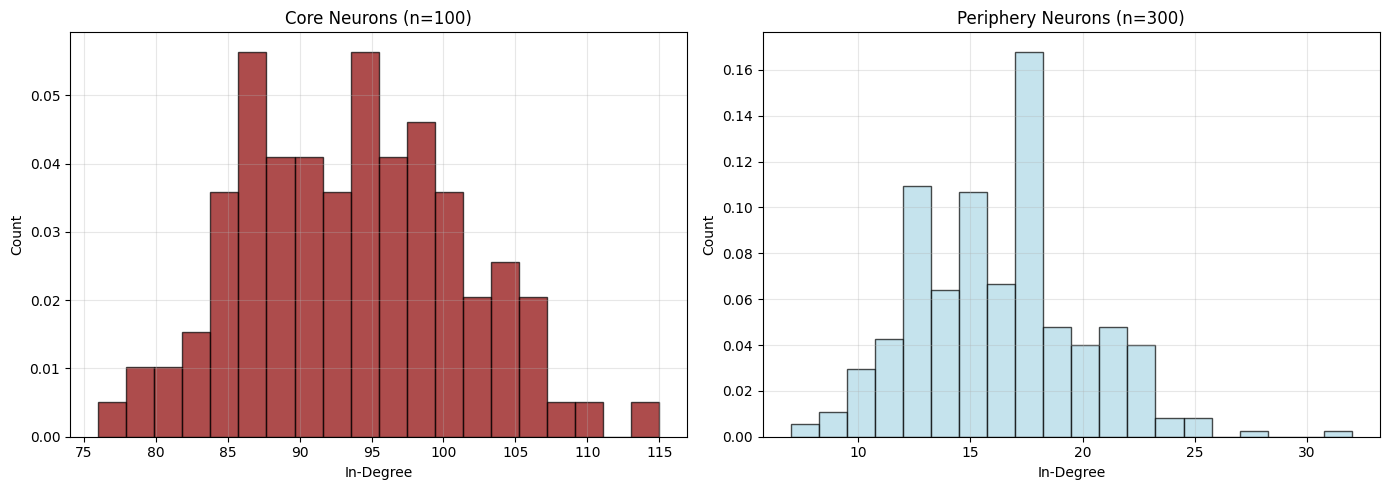


Degree Statistics:
  Core - Mean: 93.6, Std: 7.8
  Periphery - Mean: 16.2, Std: 3.7

Core neurons have ~5.8× more connections


In [17]:
# Calculate degrees
in_degree_cp = np.bincount(result_cp.post_indices, minlength=400)

# Separate core and periphery
core_degrees = in_degree_cp[:100]
periphery_degrees = in_degree_cp[100:]

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

vis.distribution_plot(
    core_degrees,
    bins=20,
    alpha=0.7,
    colors=['darkred'],
    edgecolor='black',
    ax=axes[0],
    xlabel='In-Degree',
    ylabel='Count',
    title='Core Neurons (n=100)'
)

vis.distribution_plot(
    periphery_degrees,
    bins=20,
    alpha=0.7,
    colors=['lightblue'],
    edgecolor='black',
    ax=axes[1],
    xlabel='In-Degree',
    ylabel='Count',
    title='Periphery Neurons (n=300)'
)

plt.tight_layout()
plt.show()

print(f"\nDegree Statistics:")
print(f"  Core - Mean: {np.mean(core_degrees):.1f}, Std: {np.std(core_degrees):.1f}")
print(f"  Periphery - Mean: {np.mean(periphery_degrees):.1f}, Std: {np.std(periphery_degrees):.1f}")
print(f"\nCore neurons have ~{np.mean(core_degrees) / np.mean(periphery_degrees):.1f}× more connections")

### 7.3 Visualizing Core-Periphery Structure

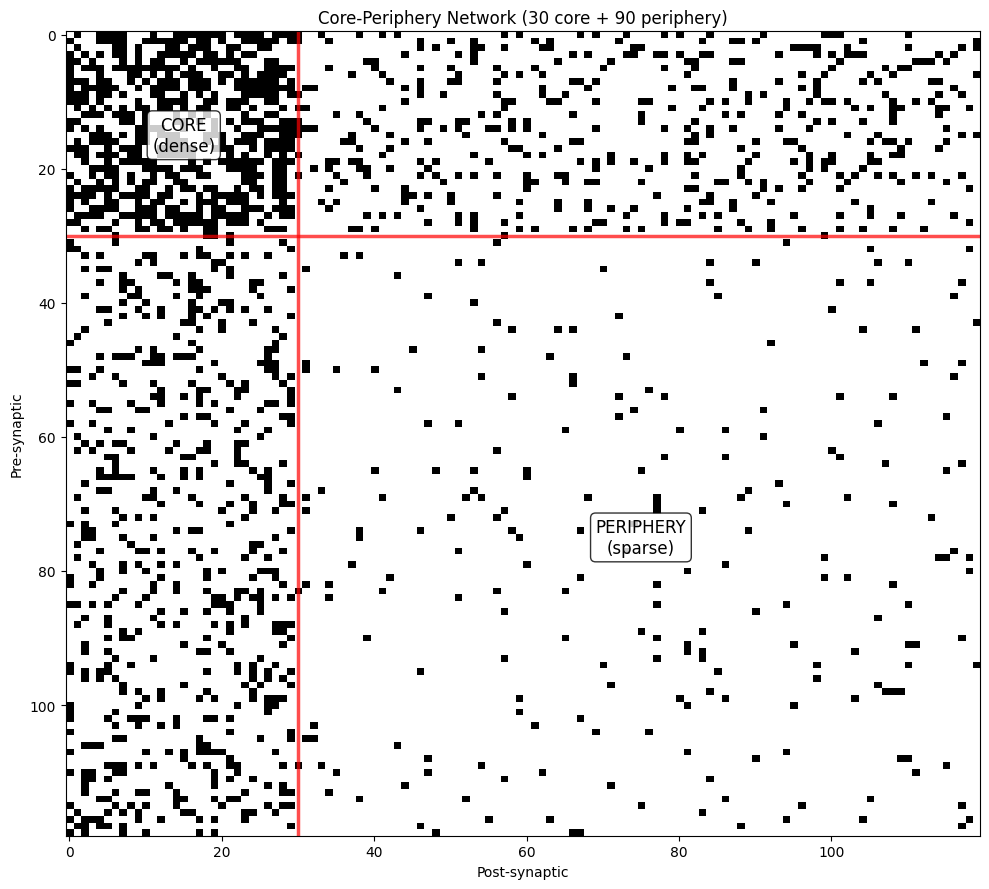


Red lines separate core and periphery.
Top-left block (core-core) is densely connected.
Bottom-right block (periphery-periphery) is sparsely connected.


In [19]:
# Create smaller network for visualization
cp_viz = conn.CorePeripheryRandom(
    core_size=30,
    core_core_prob=0.6,
    core_periphery_prob=0.15,
    periphery_core_prob=0.2,
    periphery_periphery_prob=0.03,
    seed=42
)(pre_size=120, post_size=120)

matrix_cp = result_to_matrix(cp_viz, 120)

# Plot
fig, ax = plt.subplots(figsize=(10, 9))
vis.connectivity_matrix(
    matrix_cp,
    cmap='binary',
    center_zero=False,
    show_colorbar=False,
    ax=ax,
    title='Core-Periphery Network (30 core + 90 periphery)'
)

# Add core boundary
ax.axhline(30, color='red', linewidth=2.5, alpha=0.7)
ax.axvline(30, color='red', linewidth=2.5, alpha=0.7)

# Add text labels
ax.text(15, 15, 'CORE\n(dense)', ha='center', va='center',
        fontsize=12, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax.text(75, 75, 'PERIPHERY\n(sparse)', ha='center', va='center',
        fontsize=12, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("\nRed lines separate core and periphery.")
print("Top-left block (core-core) is densely connected.")
print("Bottom-right block (periphery-periphery) is sparsely connected.")

---

## 8. Network Analysis <a name="analysis"></a>

Compare topological properties across different network types.

### 8.1 Degree Distribution Comparison

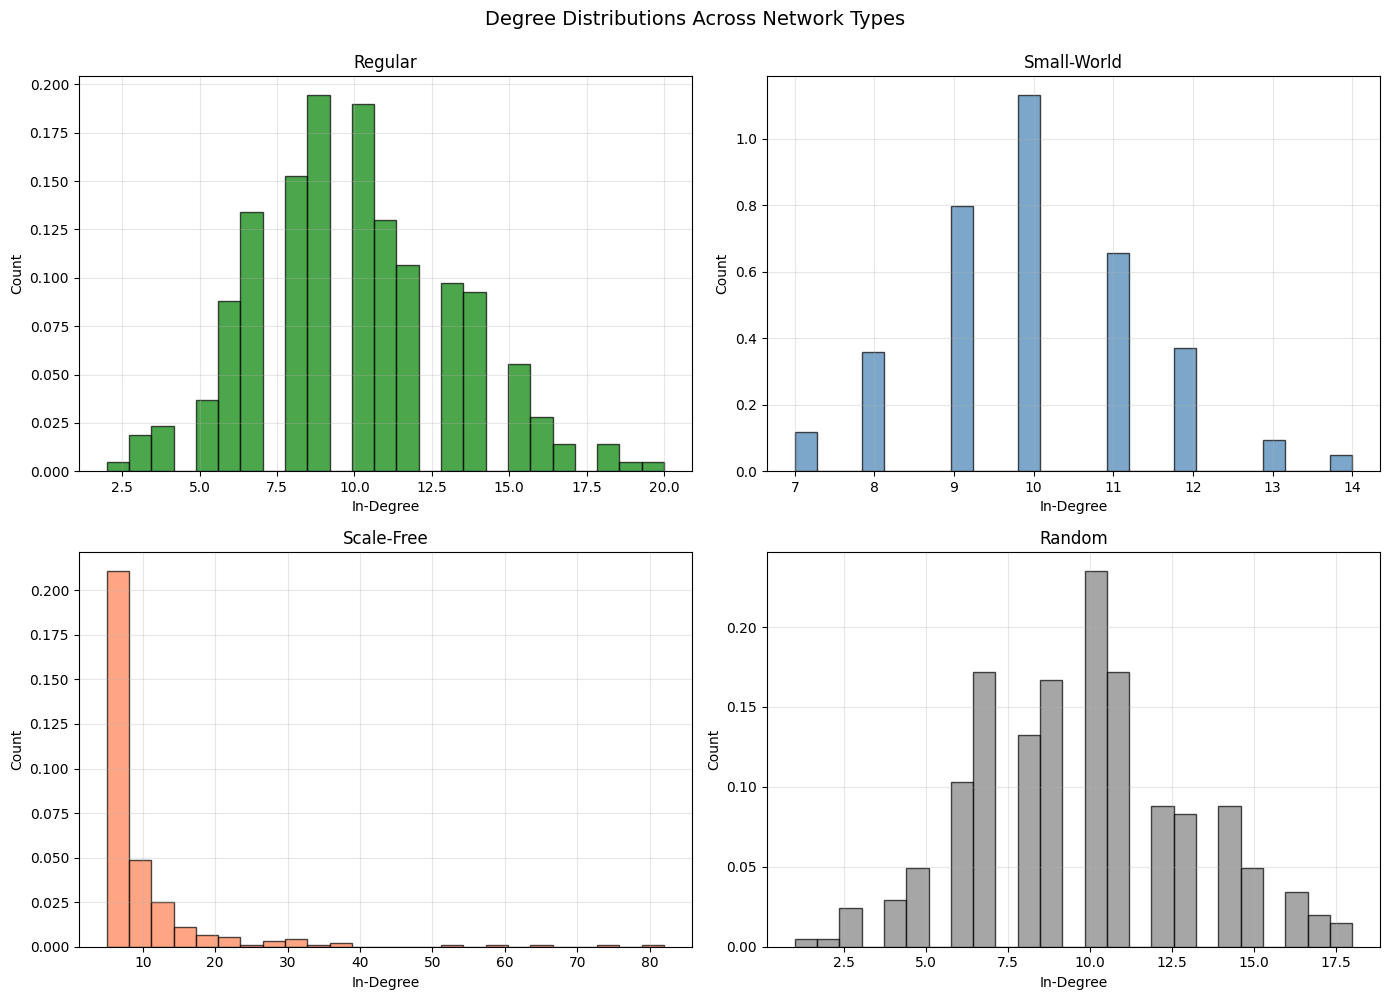

In [20]:
# Create test networks with comparable sizes
n_compare = 300

networks = {
    'Regular': conn.Regular(degree=10, seed=42)(pre_size=n_compare, post_size=n_compare),
    'Small-World': conn.SmallWorld(k=10, p=0.1, seed=42)(pre_size=n_compare, post_size=n_compare),
    'Scale-Free': conn.ScaleFree(m=5, seed=42)(pre_size=n_compare, post_size=n_compare),
    'Random': conn.Random(prob=0.033, seed=42)(pre_size=n_compare, post_size=n_compare),
}

# Calculate degree distributions
degrees = {}
for name, result in networks.items():
    in_deg = np.bincount(result.post_indices, minlength=n_compare)
    degrees[name] = in_deg

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

colors = {'Regular': 'green', 'Small-World': 'steelblue',
          'Scale-Free': 'coral', 'Random': 'gray'}

for idx, (name, deg) in enumerate(degrees.items()):
    vis.distribution_plot(
        deg,
        bins=25,
        alpha=0.7,
        colors=[colors[name]],
        edgecolor='black',
        ax=axes[idx],
        xlabel='In-Degree',
        ylabel='Count',
        title=name
    )

plt.suptitle('Degree Distributions Across Network Types', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

### 8.2 Summary Statistics Table

In [21]:
# Calculate summary statistics
print("Network Topology Comparison:")
print("=" * 80)
print(f"{'Network':<15} {'Connections':<12} {'Mean Deg':<12} {'Std Deg':<12} {'CV':<12}")
print("=" * 80)

for name, result in networks.items():
    deg = degrees[name]
    n_conn = len(result.pre_indices)
    mean_deg = np.mean(deg)
    std_deg = np.std(deg)
    cv = std_deg / mean_deg if mean_deg > 0 else 0

    print(f"{name:<15} {n_conn:<12} {mean_deg:<12.2f} {std_deg:<12.2f} {cv:<12.3f}")

print("\nCV = Coefficient of Variation (std/mean)")
print("Low CV: Homogeneous connectivity (Regular, Small-World)")
print("High CV: Heterogeneous connectivity (Scale-Free)")

Network Topology Comparison:
Network         Connections  Mean Deg     Std Deg      CV          
Regular         3000         10.00        3.19         0.319       
Small-World     3000         10.00        1.40         0.140       
Scale-Free      2970         9.90         9.44         0.953       
Random          2923         9.74         3.20         0.328       

CV = Coefficient of Variation (std/mean)
Low CV: Homogeneous connectivity (Regular, Small-World)
High CV: Heterogeneous connectivity (Scale-Free)


---

## 9. Exercises <a name="exercises"></a>

Try these exercises to reinforce your understanding:

### Exercise 1: Small-World Transition

Analyze how network properties change with rewiring probability:

In [ ]:
def analyze_small_world_transition(n_neurons=200, k=6, p_values=None):
    """
    Analyze small-world transition by measuring clustering and path length.
    
    For each rewiring probability p:
    1. Create network
    2. Calculate clustering coefficient (local connectivity)
    3. Estimate path length (requires graph algorithms)
    
    Parameters
    ----------
    n_neurons : int
        Network size
    k : int
        Number of neighbors
    p_values : list
        Rewiring probabilities to test
    
    Returns
    -------
    results : dict
        Dictionary with clustering and path length for each p
    """
    # YOUR CODE HERE
    # Hint: Clustering coefficient measures local connectivity density
    # For neuron i: C_i = (actual triangles) / (possible triangles)

    pass

# Test the function
# results = analyze_small_world_transition()
# 
# # Plot results
# p_vals = sorted(results.keys())
# clustering = [results[p]['clustering'] for p in p_vals]
# 
# plt.figure(figsize=(10, 6))
# plt.plot(p_vals, clustering, 'o-', linewidth=2)
# plt.xlabel('Rewiring Probability (p)')
# plt.ylabel('Clustering Coefficient')
# plt.title('Small-World Transition')
# plt.grid(True, alpha=0.3)
# plt.show()

### Exercise 2: Custom Modular Architecture

Design a multi-level modular network (modules within modules):

In [ ]:
def create_hierarchical_modular_network(n_super_modules=2, n_sub_modules=3, neurons_per_sub=50):
    """
    Create a hierarchical modular network with super-modules containing sub-modules.
    
    Structure:
    - Super-module 1
      - Sub-module 1a
      - Sub-module 1b
      - Sub-module 1c
    - Super-module 2
      - Sub-module 2a
      - Sub-module 2b
      - Sub-module 2c
    
    Connection rules:
    - High connectivity within sub-modules
    - Medium connectivity between sub-modules in same super-module
    - Low connectivity between super-modules
    
    Returns
    -------
    result : ConnectionResult
        Hierarchical modular connectivity
    """
    # YOUR CODE HERE
    # Hint: Use ModularGeneral with custom probability matrix

    pass

# Test your function
# result = create_hierarchical_modular_network()
# print(f"Created hierarchical modular network with {len(result.pre_indices)} connections")

### Exercise 3: Network Resilience Analysis

Compare how different topologies respond to neuron removal:

In [ ]:
def analyze_network_resilience(result, removal_fraction=0.2, strategy='random'):
    """
    Analyze network resilience by simulating neuron removal.
    
    Parameters
    ----------
    result : ConnectionResult
        Network to analyze
    removal_fraction : float
        Fraction of neurons to remove
    strategy : str
        'random': Remove random neurons
        'targeted': Remove highest-degree neurons (hub attack)
    
    Returns
    -------
    metrics : dict
        Network metrics before and after removal:
        - remaining_connections: fraction of connections preserved
        - largest_component: size of largest connected component
    """
    # YOUR CODE HERE
    # Hint: Compare scale-free (vulnerable to hub attacks) vs. 
    # small-world (more resilient)

    pass

# Test on different networks
# for name, result in networks.items():
#     metrics_random = analyze_network_resilience(result, strategy='random')
#     metrics_targeted = analyze_network_resilience(result, strategy='targeted')
#     
#     print(f"{name}:")
#     print(f"  Random removal: {metrics_random['remaining_connections']:.1%} connections remain")
#     print(f"  Targeted removal: {metrics_targeted['remaining_connections']:.1%} connections remain")